## Time series project: anomaly detection

In [1]:
pip install -r ../requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.5 MB/s eta 0:00:0031m31.4 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 145.4 MB/s eta 0:00:00m eta 0:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 135.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 120.8 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 28.2 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 162.5 MB/s eta 0:00:001m244.1 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 175.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 145.1 MB/s eta 0:00:00m eta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [9]:
#!pip install seaborn
#!pip install statsmodels
#!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 34.5 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 137.4 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


Step 1:

In Machine Learning ARIMA model is generally a class of statistical models that give outputs which are linearly dependent on their previous values in the combination of stochastic factors.

We need to visualize the data to analyse the trends, seasonalities, and cycles.

We'll start by importing necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
from pmdarima.arima import auto_arima

Step 2:

Load the datasets.



In [2]:
train_a = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-train-a.csv')
train_b = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-train-b.csv')

test_a = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-test-a.csv')
test_b = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-test-b.csv')

In [4]:
train_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  420 non-null    object 
 1   cpu       420 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.7+ KB


In [13]:
train_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  600 non-null    object 
 1   cpu       600 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.5+ KB


In [6]:
train_a

,datetime,cpu
0,2017-01-27 18:42:00,1.14
1,2017-01-27 18:43:00,1.10
2,2017-01-27 18:44:00,1.09
3,2017-01-27 18:45:00,1.08
4,2017-01-27 18:46:00,1.08
...,...,...
415,2017-01-28 01:37:00,2.41
416,2017-01-28 01:38:00,2.16
417,2017-01-28 01:39:00,1.93
418,2017-01-28 01:40:00,2.14


In [3]:
df_interim_a = train_a.copy()
df_interim_b = train_b.copy()

df_interim_a['datetime'] = pd.to_datetime(df_interim_a['datetime'])
df_interim_b['datetime'] = pd.to_datetime(df_interim_b['datetime'])

In [4]:
df_interim_a = df_interim_a.set_index(df_interim_a['datetime'])
df_interim_b = df_interim_b.set_index(df_interim_b['datetime'])

In [16]:
df_interim_a

,datetime,cpu
datetime,,
2017-01-27 18:42:00,2017-01-27 18:42:00,1.14
2017-01-27 18:43:00,2017-01-27 18:43:00,1.10
2017-01-27 18:44:00,2017-01-27 18:44:00,1.09
2017-01-27 18:45:00,2017-01-27 18:45:00,1.08
2017-01-27 18:46:00,2017-01-27 18:46:00,1.08
...,...,...
2017-01-28 01:37:00,2017-01-28 01:37:00,2.41
2017-01-28 01:38:00,2017-01-28 01:38:00,2.16
2017-01-28 01:39:00,2017-01-28 01:39:00,1.93


In [5]:
# Drop colum 

df_interim_a = df_interim_a.drop('datetime', axis=1)
df_interim_b = df_interim_b.drop('datetime', axis=1)

In [18]:
df_interim_a

,cpu
datetime,
2017-01-27 18:42:00,1.14
2017-01-27 18:43:00,1.10
2017-01-27 18:44:00,1.09
2017-01-27 18:45:00,1.08
2017-01-27 18:46:00,1.08
...,...
2017-01-28 01:37:00,2.41
2017-01-28 01:38:00,2.16
2017-01-28 01:39:00,1.93


In [6]:
df_a = df_interim_a.copy()
df_b = df_interim_b.copy()

In [25]:
df_a.describe()

,cpu
count,420.000000
mean,1.233262
std,0.505668
min,0.570000
25%,0.787500
50%,1.110000
75%,1.582500
max,2.550000


In [21]:
df_b.describe()

,cpu
count,600.000000
mean,1.282733
std,0.484951
min,0.570000
25%,0.840000
50%,1.240000
75%,1.610000
max,2.550000


Step 3:

Using matplotlib visualize the data.

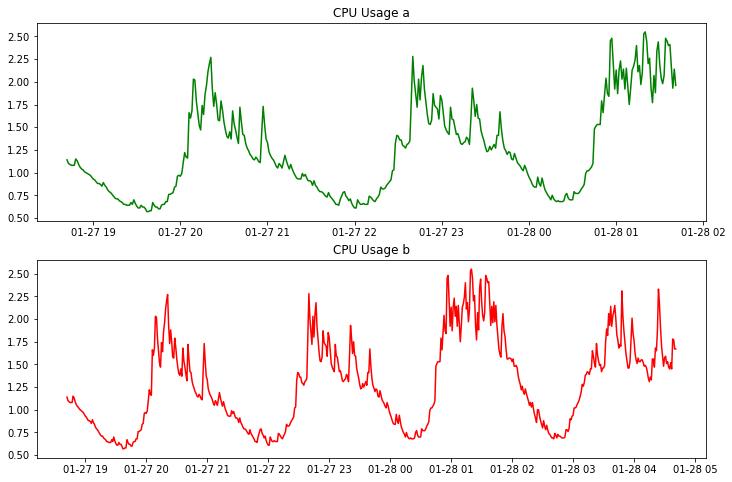

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(df_a, c='g')
ax[0].set_title("CPU Usage a")

ax[1].plot(df_b, c='r')
ax[1].set_title("CPU Usage b")

plt.show()

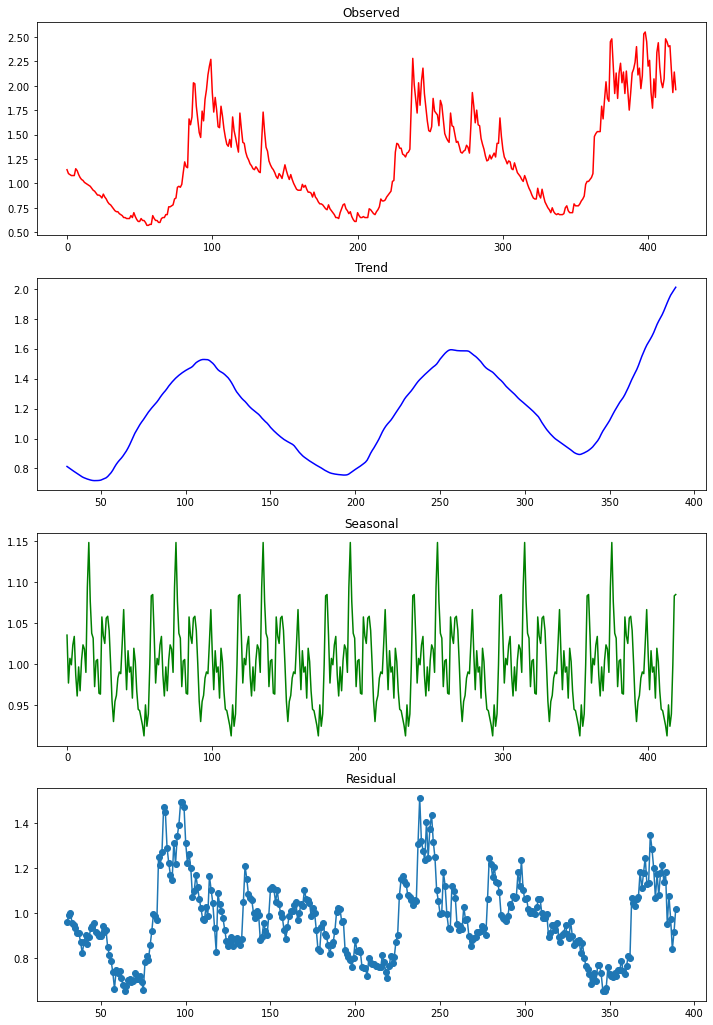

In [26]:
descomp = seasonal_decompose(df_a['cpu'].values, period=60, model='multiplicative') 

descomp_observed = descomp.observed
descomp_trend = descomp.trend
descomp_seasonal = descomp.seasonal
descomp_residual = descomp.resid

fig,ax = plt.subplots(4, figsize=(12,18))

ax[0].set_title('Observed')
ax[0].plot(descomp_observed, c='r')

ax[1].set_title('Trend')
ax[1].plot(descomp_trend, c='b')

ax[2].set_title('Seasonal')
ax[2].plot(descomp_seasonal, c='g')

ax[3].set_title('Residual')
ax[3].plot(descomp_residual)
ax[3].scatter(y=descomp_residual, x=range(len(descomp_residual)))

plt.show()

Step 4:

Use the ARIMA model to fit the data.

In [75]:
stepwise_model = auto_arima(df_a, start_p=1, start_q=1,
                           max_p=1, max_q=1, m=5,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=-245.163, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=-361.536, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=0.52 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=-243.313, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=-447.907, Time=0.38 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=2.00 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=-447.753, Time=0.24 sec
 ARIMA(1,1,1)(2,1,0)[5]             : AIC=-460.675, Time=1.04 sec
 ARIMA(1,1,1)(1,1,0)[5]             : AIC=-363.766, Time=0.26 sec
 ARIMA(1,1,1)(2,1,1)[5]             : AIC=inf, Time=1.93 sec
 ARIMA(1,1,1)(1,1,1)[5]             : AIC=inf, Time=0.65 sec
 ARIMA(0,1,1)(2,1,0)[5]             : AIC=-448.677, Time=0.36 sec
 ARIMA(1,1,1)(2,1,0)[5] intercept   : AIC=-458.672, Time=2.50 s

In [76]:
stepwise_model.fit(df_a)

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 5),
      suppress_warnings=True, with_intercept=False)

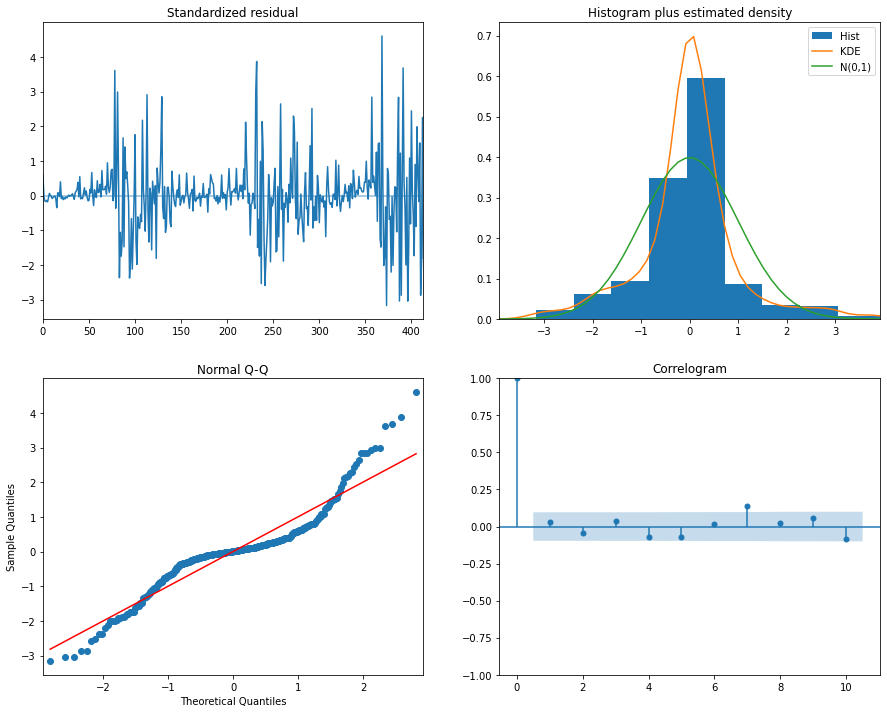

In [77]:
stepwise_model.fit(df_a).plot_diagnostics(figsize=(15, 12))
plt.show()

In [73]:
forecast_a = stepwise_model.predict(n_periods=60)

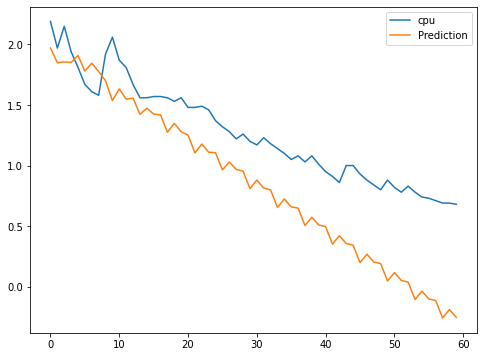

In [74]:
forecast_a = pd.DataFrame(forecast_a,index = test_a.index,columns=['Prediction'])
pd.concat([test_a,forecast_a],axis=1).plot(figsize=(8, 6))
plt.show()

<AxesSubplot:>

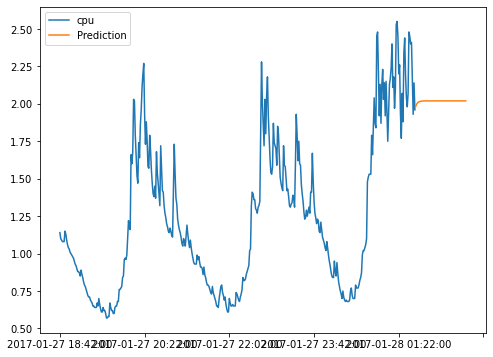

In [60]:
pd.concat([df_a,forecast_a],axis=1).plot(figsize=(8, 6))

In [40]:
stepwise_model = auto_arima(df_b, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=3,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[3]             : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,1,0)[3]             : AIC=-365.917, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[3]             : AIC=-558.201, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[3]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(0,1,0)[3]             : AIC=-365.598, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[3]             : AIC=-640.385, Time=0.15 sec
 ARIMA(1,1,0)(2,1,1)[3]             : AIC=inf, Time=0.92 sec
 ARIMA(1,1,0)(1,1,1)[3]             : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(2,1,0)[3]             : AIC=-641.102, Time=0.09 sec
 ARIMA(0,1,0)(1,1,0)[3]             : AIC=-559.939, Time=0.05 sec
 ARIMA(0,1,0)(2,1,1)[3]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,0)(1,1,1)[3]             : AIC=inf, Time=0.29 sec
 ARIMA(0,1,1)(2,1,0)[3]             : AIC=-640.657, Time=0.16 sec
 ARIMA(1,1,1)(2,1,0)[3]             : AIC=inf, Time=0.59 sec
 ARIMA(0,1,0)(2,1,0)[3] intercept   : AIC=-639.104, Time=0.24 sec

B

In [41]:
stepwise_model.fit(df_b)

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 3),
      suppress_warnings=True, with_intercept=False)

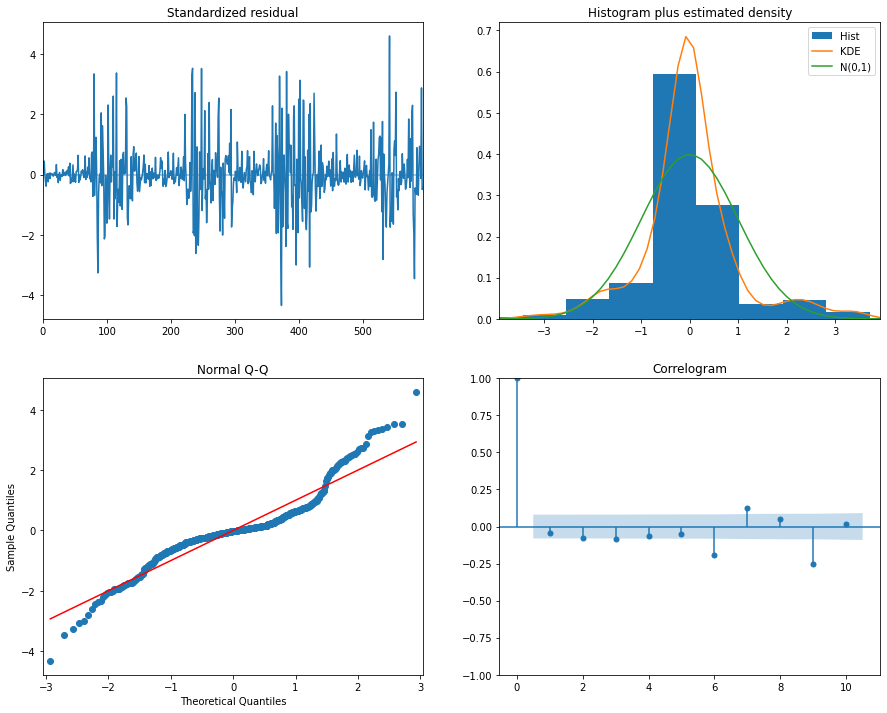

In [42]:
stepwise_model.fit(df_b).plot_diagnostics(figsize=(15, 12))
plt.show()

In [43]:
forecast_b = stepwise_model.predict(n_periods=60)

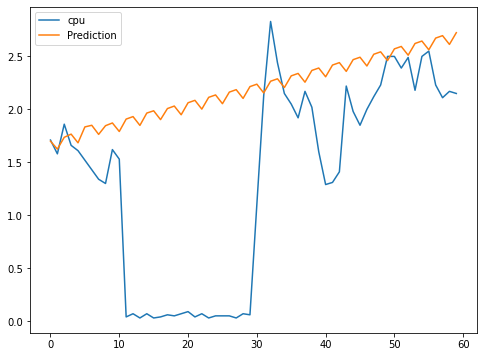

In [44]:
forecast_b = pd.DataFrame(forecast_b,index = test_b.index,columns=['Prediction'])
pd.concat([test_b,forecast_b],axis=1).plot(figsize=(8, 6))
plt.show()

<AxesSubplot:>

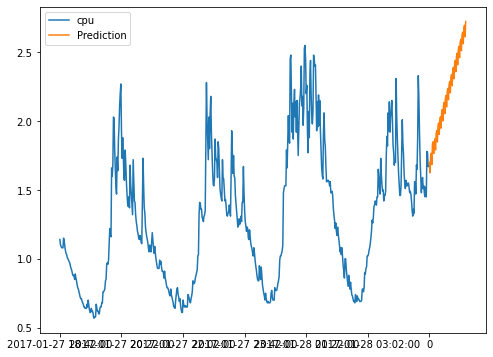

In [45]:
pd.concat([df_b,forecast_b],axis=1).plot(figsize=(8, 6))